https://www.cnblogs.com/tianqizhi/p/9277376.html

In [1]:
import mpl_finance as mpf
import matplotlib
import datetime
import matplotlib.pyplot as plt
from matplotlib.pylab import date2num 
import pandas as pd
import numpy as np
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 获取数据

In [5]:
import tushare as ts
pro=ts.pro_api('5f2dc9d17ebed3601a4fbea74148a25067d067138bf88515693e9b7d')

df = pro.daily(ts_code='000001.SZ',start_date='20020101', end_date='20190201',fields='trade_date,open,high  , low,  close')
df['trade_date']=df['trade_date'].astype('datetime64')
df=df.set_index('trade_date')
df=df.sort_index(ascending=True)
df.head()

,open,high,low,close
trade_date,,,,
2002-01-04,12.28,12.30,12.07,12.11
2002-01-07,12.11,12.20,11.95,12.04
2002-01-08,12.02,12.18,12.00,12.02
2002-01-09,12.00,12.05,11.85,11.89
2002-01-10,11.85,11.90,11.48,11.81


# 数据处理-重采样

In [6]:
df_week=df.resample('W-MON').mean()
df_week.head()

,open,high,low,close
trade_date,,,,
2002-01-07,12.195,12.250,12.010,12.075
2002-01-14,11.818,11.874,11.566,11.652
2002-01-21,10.638,10.776,10.296,10.392
2002-01-28,9.978,10.320,9.726,10.028
2002-02-04,10.020,10.360,9.910,10.228


# 训练集和测试集划分

In [7]:
# 法一
n_sample=df_week.shape[0]
n_train=int(0.95*n_sample)+1  
n_forcast=n_sample-n_train

df_train=df_week.iloc[:n_train]['close']
df_test=df_week.iloc[n_train:]['close']

#法二--直接截取某段时间，如2000-2014年的作为测试集
# df_train=df_week['close']['2002':'2014']

df_train.head()
df_train.tail()

trade_date
2002-01-07    12.075
2002-01-14    11.652
2002-01-21    10.392
2002-01-28    10.028
2002-02-04    10.228
Freq: W-MON, Name: close, dtype: float64

trade_date
2018-03-05    12.036
2018-03-12    12.076
2018-03-19    11.824
2018-03-26    11.530
2018-04-02    10.898
Freq: W-MON, Name: close, dtype: float64

Text(0.5, 1.0, '收盘价测试集')

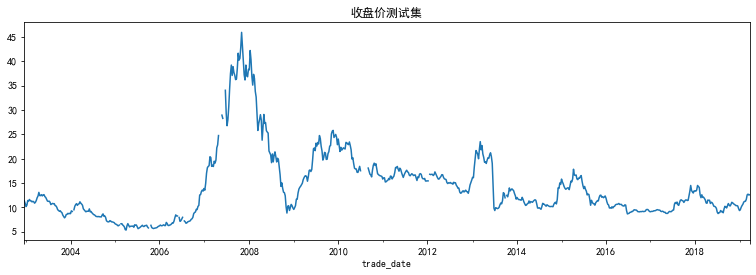

In [92]:
df_train.plot(figsize=(13,4))
plt.title('收盘价测试集')
# sns.despine()

# 确定p，d，q
由上图中的图形可以判断数据并不是平稳的，需要进行平稳化处理

## 差分

In [93]:
diff=df_train.diff()
diff_train=diff.dropna()
diff_train.head(3)

trade_date
2002-12-30   -0.521
2003-01-06   -0.644
2003-01-13    0.288
Name: close, dtype: float64

Text(0.5, 1.0, '收盘价一阶差')

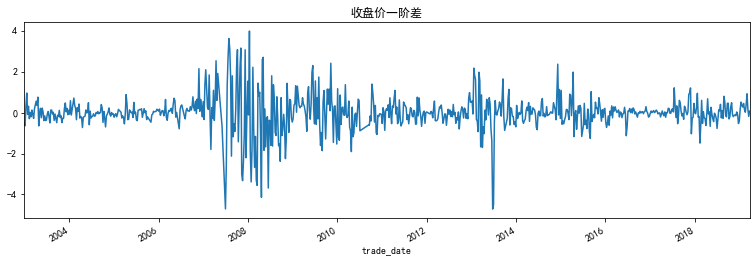

In [94]:
diff_train.plot(figsize=(13,4))
plt.title('收盘价一阶差')

## acf和pacf法

In [8]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from statsmodels.tsa.stattools import adfuller as ADF
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf


此种调用方法亦可
sm.graphics.tsa.plot_acf
sm.graphics.tsa.plot_pacf
sm.tsa.SARIMAX
sm.tsa.ARIMA

Text(0.5, 1.0, 'ACF图')

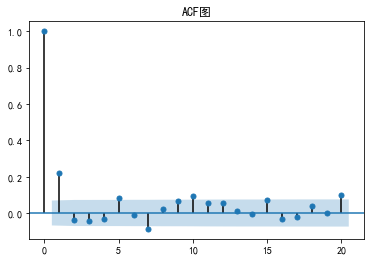

In [96]:
acf=plot_acf(diff_train,lags=20) #为1
plt.title('ACF图')

Text(0.5, 1.0, 'PACF图')

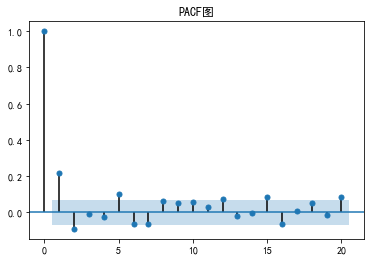

In [97]:
pacf=plot_pacf(diff_train,lags=20) #为1 
plt.title('PACF图')

## 遍历法-集合热力图
当通过acf和pacf无法判断出一个最准确的pdq组合时，
可通过遍历的方法，对多个可能的组合进行一一比较，通过BIC和AIC的数值指标，从中挑选出最有可能的组合

### for循环遍历

In [10]:
import itertools
p_min=0
d_min=0
q_min=0
p_max=4
d_max=0
q_max=4
results_bic=pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])
results_bic.head()

,MA0,MA1,MA2,MA3,MA4
AR0,NaN,NaN,NaN,NaN,NaN
AR1,NaN,NaN,NaN,NaN,NaN
AR2,NaN,NaN,NaN,NaN,NaN
AR3,NaN,NaN,NaN,NaN,NaN
AR4,NaN,NaN,NaN,NaN,NaN


In [20]:
import itertools
#当多组值都不符合时，遍历多组值，得出最好的值
p_min = 0
d_min = 0
q_min = 0
p_max = 4
d_max = 0
q_max = 4
 
# Initialize a DataFrame to store the results
results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])
 
for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue
     
    try:
        model = sm.tsa.SARIMAX(df_train, order=(p, d, q),
                               #enforce_stationarity=False,
                               #enforce_invertibility=False,
                              )
        results = model.fit()
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic  #得到bic的值，也可以得到aic的值
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float)
results_bic


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum

,MA0,MA1,MA2,MA3,MA4
AR0,NaN,5857.645420,4973.555967,4341.938912,3824.274999
AR1,2135.636165,2099.949857,2105.172455,2111.876001,2117.435784
AR2,2105.766225,2105.099696,2111.845326,2118.593913,2122.111778
AR3,2105.289335,2111.650635,2118.097923,2116.377402,2121.007064
AR4,2111.976106,2117.279126,2122.627265,2119.842006,2125.263269


### 画热力图
法一：将不同指标的结果通过热图的方式展示出来，挑选结果最小的即是最佳方案

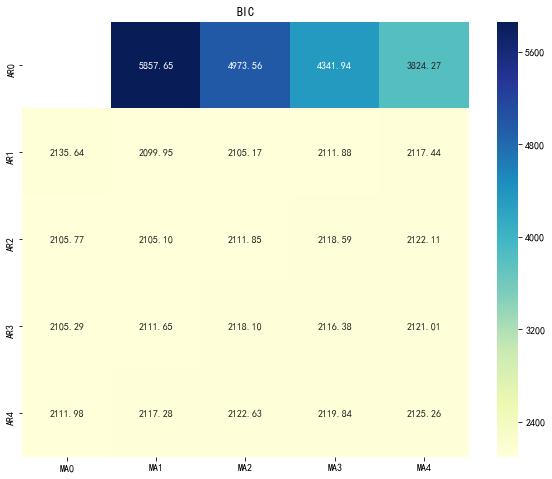

In [25]:
#annot参数为是否显示数据标签，fmt设置的是样式如：‘g’
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(results_bic,
                 mask=results_bic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',cmap="YlGnBu")
ax.set_title('BIC');

## aic、bic法--比较多组结果
法二：通过下法会分别得出aic、bic最佳时候的组合，可能会出现不一样的情况，需要再进行判断

In [41]:
train_results=sm.tsa.arma_order_select_ic(diff_train,ic=['aic','bic'],trend='nc',max_ar=4,max_ma=4)
train_results.aic_min_order
train_results.bic_min_order

(2, 4)

(0, 1)

# 建立模型
以下几步需要分开写，否则报错

In [9]:
model=sm.tsa.SARIMAX(df_train,order=(1,1,1)) #SARIMAX才有plot_diagnostics方法
# model=ARIMA(stock_train,order=(1,1,1),freq='W-MON') 也可

In [10]:
arima_result=model.fit()
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  close   No. Observations:                  848
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1035.565
Date:                Sun, 26 Jan 2020   AIC                           2077.130
Time:                        21:28:13   BIC                           2091.355
Sample:                    01-07-2002   HQIC                          2082.580
                         - 04-02-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2034      0.079     -2.560      0.010      -0.359      -0.048
ma.L1          0.4379      0.078      5.646      0.000       0.286       0.590
sigma2         0.7076      0.017     40.657      0.000       0.673       0.742
===================================================================================
Ljung-Box (Q):                       73.18   Jarque-Bera (JB):              1510.72
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.82   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# 预测

In [12]:
df_week.tail()

,open,high,low,close
trade_date,,,,
2019-01-07,9.4125,9.605,9.2900,9.4900
2019-01-14,9.9340,10.098,9.8600,10.0020
2019-01-21,10.3140,10.462,10.2180,10.3480
2019-01-28,10.5260,10.728,10.4700,10.6180
2019-02-04,11.0225,11.175,10.8825,11.0625


In [16]:
pre_vals=arima_result.predict(start='20190204',end='20190325', typ='levels',dynamic=True) #end的数据在样本外
pre_vals

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:1960: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


2019-02-04    10.784303
2019-02-11    10.784303
2019-02-18    10.784303
2019-02-25    10.784303
2019-03-04    10.784303
2019-03-11    10.784303
2019-03-18    10.784303
2019-03-25    10.784303
Freq: W-MON, dtype: float64

# 模型评估

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


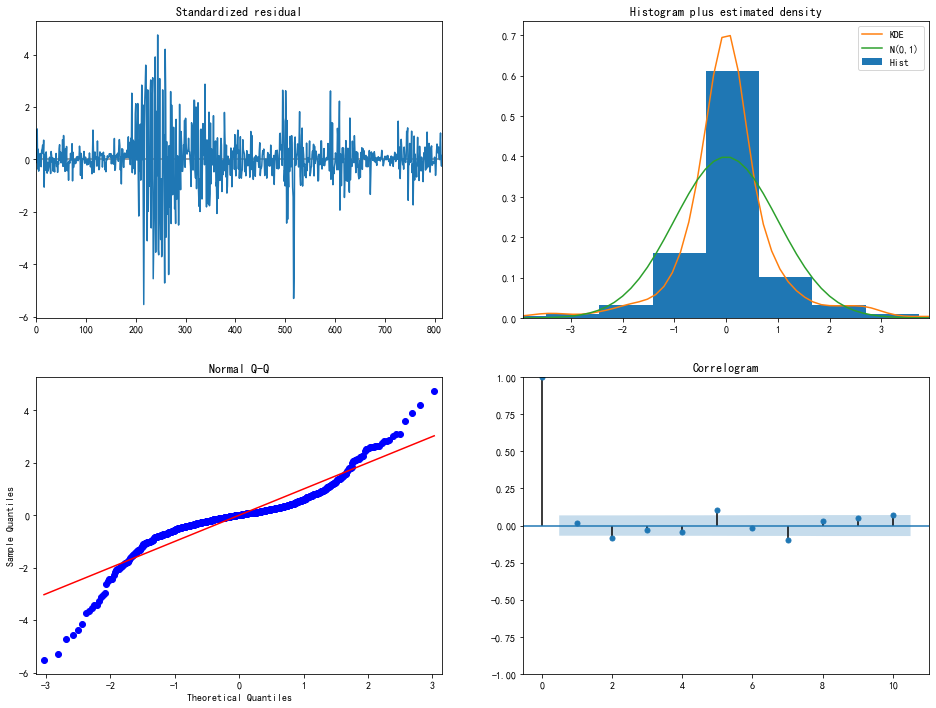

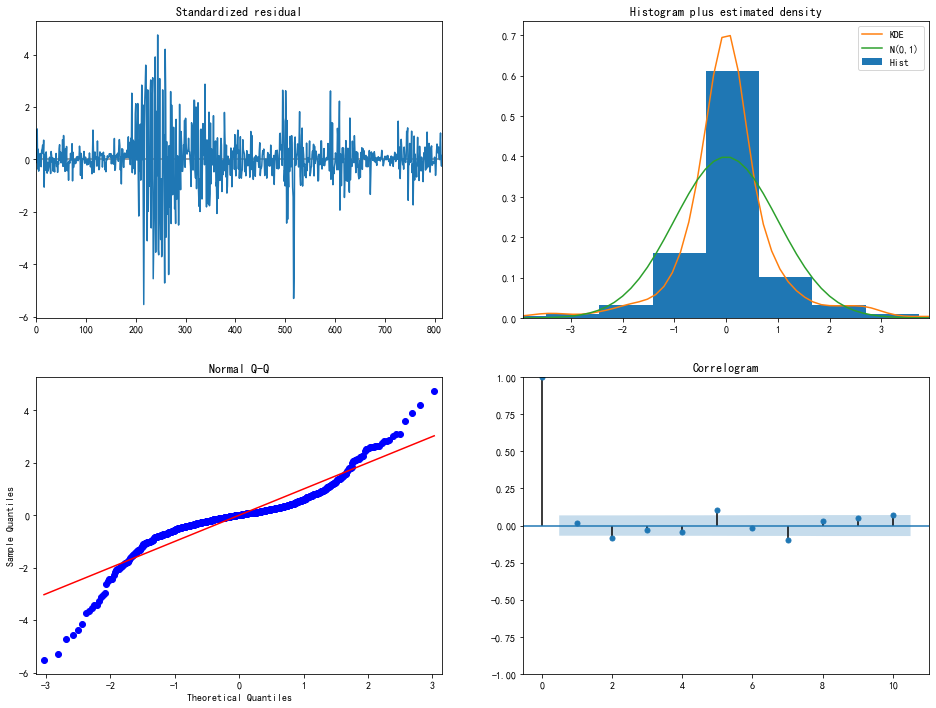

In [51]:
model=sm.tsa.SARIMAX(diff_train,order=(1,1,1)) #SARIMAX才有plot_diagnostics方法
model_results=model.fit()
model_results.plot_diagnostics(figsize=(16,12))